In [441]:
import numpy as np
import scipy.sparse.linalg as spla
import scipy.sparse as sparse

class SoftInput():
    def __init__(self, X):
        self.X = X
        self.nonzero = self.X.nonzero()
        
    def fit(self, lambdas, maxiter, tol=1e-6, start_rank=100):
        self.rank = start_rank
        self.tol = tol
        self.lambdas = np.sort(lambdas)[::-1]
        self.Z_old = sparse.csr_matrix(self.X.shape)
        self.S_old = np.zeros((self.rank,))
        self.U_old = np.zeros((self.X.shape[0], self.rank))
        self.Vt_old = np.zeros((self.rank, self.X.shape[1]))
        
        self.filled = []
        
        for l in self.lambdas:
            for i in range(maxiter):
                proj_data = np.array(self.Z_old[self.nonzero]).flatten()
                self.Z_proj = sparse.csr_matrix((proj_data, self.nonzero), shape=self.X.shape)
                lin_op = spla.LinearOperator(self.X.shape,
                                             matvec=self.matvec,
                                             rmatvec=self.rmatvec)
                U, S, Vt = spla.svds(lin_op, self.rank)
                S -= l
                S = S[S > 0]
                self.rank = S.shape[0]
                U = U[:, :self.rank]
                Vt = Vt[:self.rank, :]
                self.U_old = U
                self.Vt_old = Vt
                self.S_old = S
                self.Z_new = U.dot(np.diag(S).dot(Vt))
                if (np.linalg.norm(self.Z_new - self.Z_old) ** 2 / np.linalg.norm(self.Z_new) ** 2 < self.tol):
                    self.Z_old = self.Z_new
                    break
                self.Z_old = self.Z_new
            self.filled.append(self.Z_old)
        
        return self.lambdas, self.filled

    def matvec(self, vec):
        res = self.X.dot(vec) - self.Z_proj.dot(vec)
        res += self.U_old.dot(np.diag(self.S_old).dot(self.Vt_old.dot(vec)))
        return res
    
    def rmatvec(self, vec):
        res = self.X.T.dot(vec) - self.Z_proj.T.dot(vec)
        res += self.Vt_old.T.dot(np.diag(self.S_old).dot(self.U_old.T.dot(vec)))
        return res


In [399]:
import matplotlib.pyplot as plt
from PIL import Image

In [400]:
img = np.array(Image.open('test.png'), dtype=np.float64)[:, :, 0]

In [401]:
img[img == 0] = 100

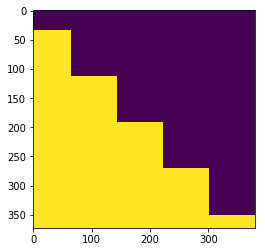

In [361]:
plt.imshow(img)
plt.show()

In [380]:
rows = np.array([], dtype=np.int)
cols = np.array([], dtype=np.int)

k_vals = np.array([-100, -50, -25, -10, -5, 0, 5, 10, 25, 50, 100, 1, 2, 3, -1, -2, -3], dtype=np.int)

for k in k_vals:
    A = sparse.eye(m=img.shape[0], n=img.shape[1], k=k)
    rows_ind, cols_ind = A.nonzero()
    rows = np.append(rows, rows_ind)
    cols = np.append(cols, cols_ind)
    
X = sparse.csr_matrix((img[(rows, cols)], (rows, cols)), shape=img.shape)

In [442]:
diags = np.arange(-99, 100, 10)
X = sparse.diags(diagonals=np.ones(diags.size), offsets=diags, shape=(100, 100))
X

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements (20 diagonals) in DIAgonal format>

In [443]:
soft_input = SoftInput(X)

In [450]:
lambdas = np.linspace(0, 2, 2)
print(lambdas)
lambdas, approximations = soft_input.fit(lambdas=lambdas, maxiter=2000, start_rank=50, tol=1e-6)

[ 0.  2.]


In [445]:
X

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements (20 diagonals) in DIAgonal format>

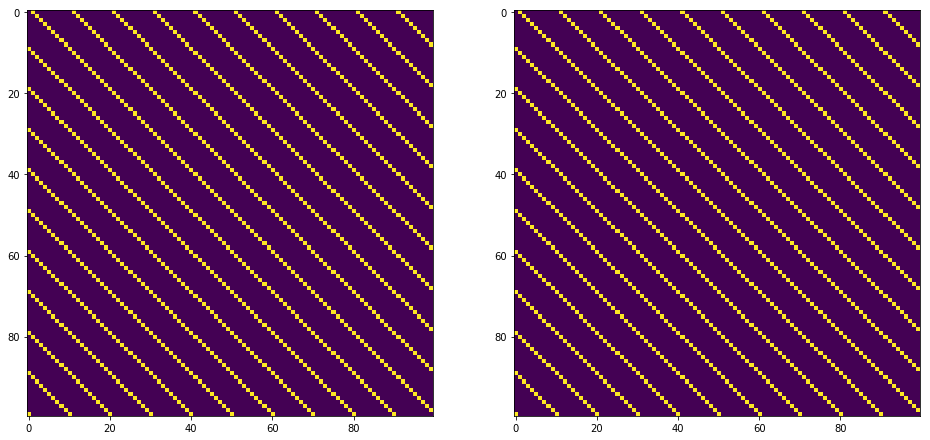

In [451]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())



plt.subplot(122)
plt.imshow(approximations[0])
plt.show()

In [389]:
np.linalg.matrix_rank(approximations[0])

47

In [370]:
approximations[0]

array([[ -1.64972003e-17,   4.11444709e-17,   1.55854184e-17, ...,
          2.49568175e-17,   7.79409361e-18,   1.75683333e-17],
       [ -6.24909648e-18,   1.55854184e-17,   5.90371587e-18, ...,
          9.45357744e-18,   2.95238235e-18,   6.65483886e-18],
       [  2.58592322e-17,  -6.44936358e-17,  -2.44300212e-17, ...,
         -3.91196159e-17,  -1.22171807e-17,  -2.75382248e-17],
       ..., 
       [ -3.12510334e-18,   7.79409361e-18,   2.95238235e-18, ...,
          4.72762847e-18,   1.47645343e-18,   3.32801057e-18],
       [ -7.04416186e-18,   1.75683333e-17,   6.65483886e-18, ...,
          1.06563453e-17,   3.32801057e-18,   7.50152638e-18],
       [  6.61468264e-18,  -1.64972003e-17,  -6.24909648e-18, ...,
         -1.00066329e-17,  -3.12510334e-18,  -7.04416186e-18]])